In [1]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request 
import tabula
import pandas as pd
import csv
import numpy as np
from urllib.error import HTTPError
import re

## Web Scraping & Feature Engineering

State Mental Health Care budgets will be added as a feature. I found per capita spend on the Kaiser Foundation website for the years 2004 to 2013. I am scraping the per capita spend from samhsa.gov for years 2014-2016.

In [2]:
#import list of states
st = pd.read_csv('data/location_/states.csv')

In [3]:
states = list(st.State)
states = [s.replace(" ","") for s in states]

In [4]:
#retrieve data for each state and year

file_names = []

years = ['2014', '2015','2016']

for year in years:
    for state in states:
        if year == '2014':
            url = f'https://www.samhsa.gov/data/sites/default/files/URSTables2014/{state}.pdf'
       
        if year == '2015':
            url = f'https://www.samhsa.gov/data/sites/default/files/{state}.pdf'
    
        if year == '2016':
            url = f'https://www.samhsa.gov/data/sites/default/files/{state}-2016.pdf'
        
        file = year +'-'+ state
        
        #download pdf files to local
        try:
            #urllib.request.urlretrieve(url, filename=f'data/scraped/{file}.pdf')
            
            #make a list of file names
            file_names.append(f'{file}.pdf')
            
        except HTTPError as err:
            if err.code == 404:
                print(url)
                
                continue
            

In [5]:
# 2014-Utah threw an error, must be removed from file list
file_names.remove('2014-Utah.pdf')

In [7]:
#use tabula to read the tables on third page of each pdf, assign per capita values to dictionary

# scraped_data = {
    
#     'state': [],
#     'budget': [],
#     'year': [],
# }

# for file in file_names:
#     year = str(file[:4])
#     state = str(file[5:].split('.')[0])
#     scraped_data['state'].append(state)
#     scraped_data['year'].append(year)
    
#     df = tabula.read_pdf(f'data/scraped/{file}', pages=3, multiple_tables=True)
   
#     #get the index of the string that contains the "per capita total"
#     ix = df[0].index[df[0]['State Revenue Expenditure Data'].str.contains('Per Capita Total SMHA')== True]
#     budget = [x for x in df[0].iloc[ix]['Amount']]
#     scraped_data['budget'].append(budget)


In [12]:
#reformat scraped data to match our others csv files

# def remove_dollar(item):
#     if len(item[0])> 2:
#         return item[0].split('$')[1]
#     else:
#         return np.nan


# scraped_df.budget = scraped_df.budget.apply(lambda x: remove_dollar(x))

# def split_name(x):
#     x = re.findall('[A-Z][^A-Z]*', x)
#     if x == ['Districtof','Columbia']:
#         x = ['District', 'of', 'Columbia']
#     return ' '.join(x)


#scraped_df.state = scraped_df.state.apply(lambda x: split_name(x))

#scraped_df.to_csv('data/scraped_data.csv')

In [86]:
#import data that was retrieved and saved above
df = pd.read_csv('data/scraped_data.csv')

In [87]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [95]:
df.budget = df.budget.astype(float)
df.year = df.year.astype(str)

In [96]:
df.head()

,state,budget,year
0,Alabama,72.64,2014
1,Alaska,341.08,2014
2,Arizona,205.23,2014
3,Arkansas,45.56,2014
4,California,160.50,2014


In [97]:
scraped_df = df.copy()

In [100]:
df14 = scraped_df.loc[scraped_df.year == '2014']
df14.rename({'budget':'2014'}, inplace=True, axis=1)
df14.drop('year', axis=1, inplace=True)

In [102]:
df15 = scraped_df.loc[scraped_df.year == '2015']
df15.rename({'budget':'2015'}, inplace=True, axis=1)
df15.drop('year', axis=1, inplace=True)

In [103]:
df16 = scraped_df.loc[scraped_df.year == '2016']
df16.rename({'budget':'2016'}, inplace=True, axis=1)
df16.drop('year', axis=1, inplace=True)

In [104]:
df_all = pd.merge(df14, df15, how='outer', on='state')

In [105]:
df_scraped = pd.merge(df_all, df16, how='outer',on='state')

In [108]:
df_scraped.head()

,state,2014,2015,2016
0,Alabama,72.64,74.62,75.22
1,Alaska,341.08,316.98,322.48
2,Arizona,205.23,216.87,270.60
3,Arkansas,45.56,42.98,42.29
4,California,160.50,174.98,185.26


### Import csv file of data from Kaiser Foundation and impute missing data

In [145]:
smha_df = pd.read_csv('data/SMHA.csv')
smha_df.rename({'Unnamed: 0': 'state'}, axis=1, inplace=True)

In [146]:
#merge scraped data with csv file
mentalhealthbudget_df = pd.merge(smha_df, df_scraped, how ='left', on ='state')

In [147]:
#check for missing data
mentalhealthbudget_df[mentalhealthbudget_df.isnull().any(axis=1) == True]

,state,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
3,Arkansas,32.95,35.60,38.58,39.72,40.53,42.77,42.02,NaN,45.05,45.56,45.56,42.98,42.29
8,District of Columbia,409.92,404.40,394.10,392.27,381.90,388.83,NaN,307.45,305.37,306.87,306.87,335.16,390.19
9,Florida,35.96,36.56,38.17,39.87,42.11,40.90,39.55,39.04,37.28,NaN,NaN,36.05,36.40
11,Hawaii,147.99,156.67,135.75,NaN,207.58,212.15,169.99,126.63,131.16,131.77,131.77,137.04,129.32
31,New Mexico,27.78,24.23,25.58,97.61,95.98,93.51,93.37,138.20,131.44,NaN,NaN,145.11,151.38
32,New York,200.02,206.21,213.23,222.58,230.80,241.59,256.31,259.55,269.60,260.78,260.78,251.12,NaN
36,Oklahoma,39.79,44.67,48.98,53.02,54.99,56.56,53.05,55.68,56.22,53.01,53.01,59.29,NaN
44,Utah,73.56,64.34,58.29,64.93,65.27,64.01,64.17,66.76,64.39,70.86,NaN,70.86,73.86


In [148]:
#find the median value for the rows that are missing data
med = mentalhealthbudget_df[mentalhealthbudget_df.isnull().any(axis=1) == True].median(axis=1)

In [149]:
#fill missing data with state median spend
for i, col in enumerate(mentalhealth_df):
    mentalhealthbudget_df.iloc[:, i] = mentalhealthbudget_df.iloc[:, i].fillna(med)

In [152]:
mentalhealthbudget_df.head()

,state,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,58.78,60.31,64.43,74.03,79.39,77.89,78.19,78.330,76.27,72.64,72.64,74.62,75.22
1,Alaska,287.56,269.64,278.63,293.16,277.03,289.71,310.01,380.330,335.36,341.08,341.08,316.98,322.48
2,Arizona,135.64,146.22,156.78,158.07,173.85,196.13,221.27,214.480,209.44,205.23,205.23,216.87,270.60
3,Arkansas,32.95,35.60,38.58,39.72,40.53,42.77,42.02,42.155,45.05,45.56,45.56,42.98,42.29
4,California,113.61,118.65,122.98,134.94,150.34,157.62,152.60,162.000,169.65,160.50,160.50,174.98,185.26


In [289]:
#reformat dataframe into three columns

def separate_data(yr,df):
    df2 = df[['state',yr]].copy()
    df2.rename({yr:'smha_per_cap'}, axis=1, inplace=True)
    df2['year'] = yr
    return df2

In [290]:
df04 = separate_data('2004',mentalhealthbudget_df)
df05 = separate_data('2005',mentalhealthbudget_df)
df06 = separate_data('2006',mentalhealthbudget_df)
df07 = separate_data('2007',mentalhealthbudget_df)
df08 = separate_data('2008',mentalhealthbudget_df)
df09 = separate_data('2009',mentalhealthbudget_df)
df10 = separate_data('2010',mentalhealthbudget_df)
df11 = separate_data('2011',mentalhealthbudget_df)
df12 = separate_data('2012',mentalhealthbudget_df)
df13 = separate_data('2013',mentalhealthbudget_df)
df14 = separate_data('2014',mentalhealthbudget_df)
df15 = separate_data('2015',mentalhealthbudget_df)
df16 = separate_data('2016',mentalhealthbudget_df)

In [291]:
frames = [df04,df05,df06,df07,df08,df09,df10,df11,df12,df13,df14,df15,df16]
mh_budget_df = pd.concat(frames, axis=0)
mh_budget_df.reset_index(inplace=True)
mh_budget_df.drop('index', axis=1, inplace=True)

In [292]:
mh_budget_df.state = mh_budget_df.state.apply(lambda x: x.lower())

In [293]:
mh_budget_df.head()

,state,smha_per_cap,year
0,alabama,58.78,2004
1,alaska,287.56,2004
2,arizona,135.64,2004
3,arkansas,32.95,2004
4,california,113.61,2004


### Import primary data set and merge

In [294]:
data = pd.read_csv('data/clean_data_set.csv')

In [300]:
data.state = data.state.astype(str)
data.year = data.year.astype(str)

In [301]:
feature_df = pd.merge(data,mh_budget_df, how ='left', on=['state','year'])

In [302]:
feature_df.head()

,Unnamed: 0,state,number,year,population,renter_occupied_households,eviction_filings,evictions,total_ssi,aged_ssi,...,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,homeless_count,smha_per_cap
0,0,alabama,AL-500,2007,845208,104742,3203,656,25480,1839,...,68.87,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2104,74.03
1,1,alabama,AL-500,2008,845208,105612,2172,976,25762,1722,...,68.87,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2104,79.39
2,2,alabama,AL-500,2009,845208,106482,1785,945,26244,1615,...,68.87,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2273,77.89
3,3,alabama,AL-500,2010,853551,107353,2486,1605,27098,1525,...,65.91,26.20,4.90,0.22,1.64,0.02,0.99,0.10,2273,78.19
4,4,alabama,AL-500,2011,862556,108846,3708,2257,27532,1459,...,64.90,26.95,4.82,0.23,1.80,0.02,1.10,0.16,1950,78.33


In [304]:
feature_df.drop('Unnamed: 0', axis=1, inplace=True)

In [306]:
#calculate total mental health spend by CoC area
feature_df['total_smha'] = feature_df['population']* feature_df['smha_per_cap']

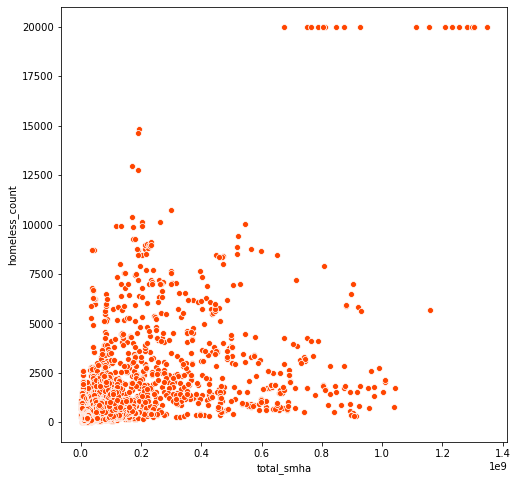

In [310]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x = feature_df['total_smha'], y = feature_df['homeless_count'], color='orangered')

In [312]:
feature_df.to_csv('data/features.csv')